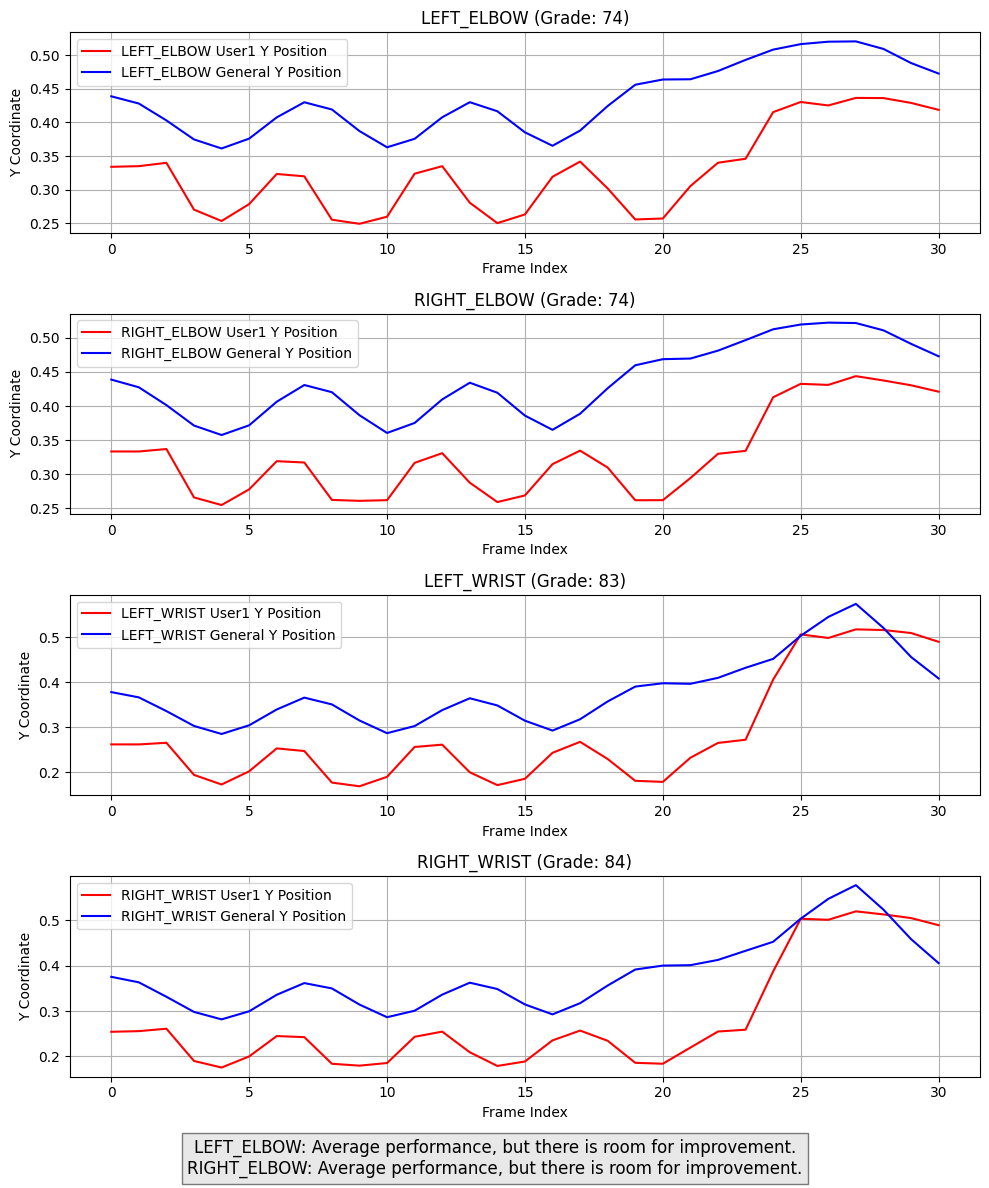

In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# MediaPipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# test_data/user1의 이미지와 비교하기 위해 user1 데이터 추출
user1_data_path = "test_data/user1"
user1_keypoints_dict = { "LEFT_ELBOW": [], "RIGHT_ELBOW": [], "LEFT_WRIST": [], "RIGHT_WRIST": []}

for img_file in sorted(os.listdir(user1_data_path)):
    img_path = os.path.join(user1_data_path, img_file)
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Pose 추론 수행
    results = pose.process(image_rgb)
    
    if results.pose_landmarks:
        # 팔꿈치, 손목 좌표 추출 및 저장
        left_elbow = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW]
        right_elbow = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW]
        left_wrist = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST]
        right_wrist = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
        
        user1_keypoints_dict["LEFT_ELBOW"].append(left_elbow.y)
        user1_keypoints_dict["RIGHT_ELBOW"].append(right_elbow.y)
        user1_keypoints_dict["LEFT_WRIST"].append(left_wrist.y)
        user1_keypoints_dict["RIGHT_WRIST"].append(right_wrist.y)

# 이동 평균 CSV 파일 로드
data = pd.read_csv("average_keypoints_V3.csv")

# 이동 패턴 그래프 그리기 (user1 데이터와 이동 평균 데이터 비교)
plt.figure(figsize=(10, 12))  # 그래프 크기 조정

correlations = []  # 상관 계수를 저장할 리스트
feedbacks = []

for i, keypoint in enumerate(user1_keypoints_dict.keys()):
    plt.subplot(4, 1, i + 1)
    # 두 데이터의 길이를 맞추기 위해 최소 길이 사용
    min_length = min(len(user1_keypoints_dict[keypoint]), len(data[keypoint].dropna()))
    user1_values = user1_keypoints_dict[keypoint][:min_length]
    moving_average_values = data[keypoint].dropna().values[:min_length]
    
    # user1 데이터 그래프
    plt.plot(range(min_length), user1_values, color='red', linestyle='-', label=f'{keypoint} User1 Y Position')
    # 이동 평균 데이터 그래프
    plt.plot(range(min_length), moving_average_values, color='blue', linestyle='-', label=f'{keypoint} General Y Position')
    
    # 상관 계수 계산 및 저장
    correlation = np.corrcoef(user1_values, moving_average_values)[0, 1] * 100
    correlations.append((keypoint, correlation))
    
    # 피드백 추가 (왼쪽 팔꿈치와 오른쪽 팔꿈치만)
    if keypoint in ["LEFT_ELBOW", "RIGHT_ELBOW"]:
        if correlation > 80:
            feedbacks.append(f"{keypoint}: The posture is close to perfect!")
        elif correlation > 70:
            feedbacks.append(f"{keypoint}: Average performance, but there is room for improvement.")
        else:
            feedbacks.append(f"{keypoint}: The Y-axis position is generally lower than the standard. Try to maintain a more consistent and higher posture.")
    
    plt.xlabel('Frame Index')
    plt.ylabel('Y Coordinate')
    plt.title(f'{keypoint} (Grade: {correlation:.0f})')
    plt.legend()
    plt.grid(True)

# 피드백을 그래프 외부에 출력
if feedbacks:
    feedback_text = "\n".join(feedbacks)
    plt.figtext(0.5, 0.02, feedback_text, wrap=True, horizontalalignment='center', fontsize=12, bbox=dict(facecolor='lightgrey', alpha=0.5))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# 유사도 계산 (상관 계수 및 평균 제곱 오차)
keypoints_pairs = [("LEFT_ELBOW", "RIGHT_ELBOW"), ("LEFT_WRIST", "RIGHT_WRIST")]

for left_keypoint, right_keypoint in keypoints_pairs:
    left_values = user1_keypoints_dict[left_keypoint]
    right_values = user1_keypoints_dict[right_keypoint]
    moving_average_left = data[left_keypoint].dropna().values  # NaN 값 제거
    moving_average_right = data[right_keypoint].dropna().values  # NaN 값 제거
    
    # 두 데이터의 길이를 맞추기 위해 최소 길이 사용
    min_length = min(len(left_values), len(moving_average_left))
    left_values = left_values[:min_length]
    moving_average_left = moving_average_left[:min_length]
    
    min_length = min(len(right_values), len(moving_average_right))
    right_values = right_values[:min_length]
    moving_average_right = moving_average_right[:min_length]
    
    # 좌우 각각의 상관 계수 계산
    correlation_left = np.corrcoef(left_values, moving_average_left)[0, 1]
    correlation_right = np.corrcoef(right_values, moving_average_right)[0, 1]
    
    # 좌우 평균 상관 계수 계산
    avg_correlation = (correlation_left + correlation_right) / 2
